# 1.1-) import libraries

In [1]:
# import essential basic libraries 
import pandas as pd
import numpy as np
from math import sqrt
from scipy.sparse.linalg import svds

# import matrix_factorization_utilities.py
from models import matrix_factorization_utilities

# import machine learning libraries 
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# import visualization  libraries 
import matplotlib.pyplot as plt
%matplotlib inline

# import deep learning libraries 
import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Activation, Flatten ,Embedding, Reshape, concatenate

# import warnings libraries for close warnings
import warnings
warnings.filterwarnings('ignore')


Bad key "text.kerning_factor" on line 4 in
C:\Users\Ali\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Instructions for updating:
non-resource variables are not supported in the long term


#  1.2-) Dataset import and config

In [2]:
# Reading the ratings data
ratings = pd.read_csv('Dataset/ratings.csv')
#Just taking the required columns
ratings = ratings[['userId', 'movieId','rating']]
#reading the movies dataset
movie_list = pd.read_csv('Dataset/movies.csv')

In [3]:
#get ordered list of movieIds
item_indices = pd.DataFrame(sorted(list(set(ratings['movieId']))),columns=['movieId'])
#add in data frame index value to data frame
item_indices['movie_index']=item_indices.index
#inspect data frame
item_indices.head()

,movieId,movie_index
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


In [4]:
#get ordered list of movieIds
user_indices = pd.DataFrame(sorted(list(set(ratings['userId']))),columns=['userId'])
#add in data frame index value to data frame
user_indices['user_index']=user_indices.index
#inspect data frame
user_indices.head()

,userId,user_index
0,1,0
1,2,1
2,3,2
3,4,3
4,5,4


In [5]:
#join the movie indices
df_with_index = pd.merge(ratings,item_indices,on='movieId')
#join the user indices
df_with_index=pd.merge(df_with_index,user_indices,on='userId')
#inspec the data frame
df_with_index.head()

,userId,movieId,rating,movie_index,user_index
0,1,2,3.5,1,0
1,1,29,3.5,28,0
2,1,32,3.5,31,0
3,1,47,3.5,46,0
4,1,50,3.5,49,0


In [6]:
# Assigning a unique value to each user and movie in range 0,no_of_users and 0,no_of_movies respectively.
ratings.userId = ratings.userId.astype('category').cat.codes.values
ratings.movieId = ratings.movieId.astype('category').cat.codes.values

In [7]:
#take 80% as the training set and 20% as the test set
train, test= train_test_split(ratings,test_size=0.2)
train.shape,test.shape

((838860, 3), (209715, 3))

In [8]:
train.head

<bound method NDFrame.head of          userId  movieId  rating
880212     5878     1481     4.0
867463     5791     1098     3.0
26942       207     8750     4.0
707989     4699      918     4.0
344891     2334     7446     3.5
...         ...      ...     ...
661685     4393     2784     5.0
1039209    7045    10131     4.0
963646     6462     3350     4.0
73530       519     5175     3.5
534585     3612     3540     5.0

[838860 rows x 3 columns]>

In [9]:
train.movieId.max()

14025

In [10]:
test.head

<bound method NDFrame.head of         userId  movieId  rating
617310    4128    11092     3.5
141407     950     6699     4.5
499840    3372      349     4.0
217647    1506     5038     1.0
274684    1886     4808     2.0
...        ...      ...     ...
775521    5156     3194     3.5
379571    2572     3215     3.5
359817    2422     7480     3.5
874969    5842      294     4.0
760304    5068      583     4.0

[209715 rows x 3 columns]>

In [11]:
n_users = ratings.userId.unique().shape[0]
n_items = ratings.movieId.unique().shape[0]
n_users, n_items

(7120, 14026)

In [12]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
    #for every line in the data
for line in train.itertuples():
    #set the value in the column and row to 
    #line[1] is userId, line[2] is movieId and line[3] is rating, line[4] is movie_index and line[5] is user_index
    train_data_matrix[line[1]-1,line[2]-1] = line[3]
train_data_matrix.shape

(7120, 14026)

In [13]:
#Create two user-item matrices, one for training and another for testing
test_data_matrix = np.zeros((n_users, n_items))
    #for every line in the data
for line in test.itertuples():
    #set the value in the column and row to 
    #line[1] is userId, line[2] is movieId and line[3] is rating, line[4] is movie_index and line[5] is user_index
    #print(line[2])
    test_data_matrix[line[1]-1,line[2]-1] = line[3]
test_data_matrix.shape

(7120, 14026)

In [14]:
pd.DataFrame(train_data_matrix).head()

,0,1,2,3,4,5,6,7,8,9,...,14016,14017,14018,14019,14020,14021,14022,14023,14024,14025
0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [15]:
train['rating'].max()

5.0

# 2-) svd to the test data and calculate rmse score of matrix factorisation for find best n_latent

In [16]:
# accuracy bulunacak

In [17]:
#Calculate the rmse sscore of SVD using different values of k (latent features)
rmse_list = []
mae_list = []
accuracy=[]
pred_list=[]
a=[1,2,5]
for i in a:
    #apply svd to the test data
    u,s,vt = svds(train_data_matrix,k=i)
    #get diagonal matrix
    s_diag_matrix=np.diag(s)
    #predict x with dot product of u s_diag and vt
    X_pred = np.dot(np.dot(u,s_diag_matrix),vt)
    pred_list.append(X_pred)
    #calculate rmse score of matrix factorisation predictions
    mse =mean_squared_error(test_data_matrix, X_pred)
    
    rmse_score = sqrt(mse)
    rmse_list.append(round(rmse_score,4))
    mae_score = mean_absolute_error(test_data_matrix,X_pred)
    mae_list.append(round(mae_score,4))

In [18]:
min_value_rmse=min(rmse_list)
min_index_rmse=rmse_list.index(min_value_rmse)
min_value_mae=min(mae_list)
min_index_mae=mae_list.index(min_value_mae)

print("Matrix Factorisation with " + str(a[min_index_rmse]) +" latent features has a RMSE of " + str(min_value_rmse))
print("Matrix Factorisation with " + str(a[min_index_mae]) +" latent features has a MAE of " + str(min_value_mae))

Matrix Factorisation with 1 latent features has a RMSE of 0.1948
Matrix Factorisation with 1 latent features has a MAE of 0.039


In [19]:
import keras
from keras.layers import Embedding, Reshape
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [21]:
movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(14026 + 1, 1, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(7120 + 1, 1,name='User-Embedding')(user_input))
prod = keras.layers.concatenate([movie_vec, user_vec],name='DotProduct')
result = keras.layers.Dense(1, activation='relu',name='Activation')(prod)
adam = Adam(lr=0.005)
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 1)         14027       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 1)         7121        User[0][0]                       
______________________________________________________________________________________________

In [23]:
history = model.fit([train.userId, train.movieId], train.rating,  epochs=10,batch_size=64,verbose=1, validation_split=0.1)

Train on 754974 samples, validate on 83886 samples
Epoch 1/10
754974/754974 [==============================] - 5s 7us/sample - loss: 0.7381 - val_loss: 0.6702
Epoch 2/10
754974/754974 [==============================] - 5s 7us/sample - loss: 0.6638 - val_loss: 0.6645
Epoch 3/10
754974/754974 [==============================] - 5s 7us/sample - loss: 0.6576 - val_loss: 0.6628
Epoch 4/10
754974/754974 [==============================] - 5s 7us/sample - loss: 0.6544 - val_loss: 0.6634
Epoch 5/10
754974/754974 [==============================] - 5s 7us/sample - loss: 0.6523 - val_loss: 0.6607
Epoch 6/10
754974/754974 [==============================] - 5s 7us/sample - loss: 0.6509 - val_loss: 0.6608
Epoch 7/10
754974/754974 [==============================] - 5s 7us/sample - loss: 0.6497 - val_loss: 0.6602
Epoch 8/10
754974/754974 [==============================] - 5s 7us/sample - loss: 0.6489 - val_loss: 0.6601
Epoch 9/10
754974/754974 [==============================] - 5s 7us/sample - loss: 0.6

In [24]:
y_hat = np.round(model.predict([test.userId, test.movieId]),0)
y_true = test.rating

In [25]:
mean_absolute_error(y_true, y_hat)

0.6510120878334883

In [26]:
def accuracy(y_true,y_hat):
    errors=mean_absolute_error(y_true, y_hat)
    mape = 100 * (errors / y_true)
    accuracy = 100 - np.mean(mape)
    return accuracy
print("(MAE)Mean Absolute Error:",round(mean_absolute_error(y_true, y_hat),4))
print("(RMSE)Root Mean Square Error:",round(np.sqrt(mean_squared_error(y_true,y_hat)) ,4))
print(' Accuracy:', round(accuracy(y_true,y_hat), 2), '%.')

(MAE)Mean Absolute Error: 0.651
(RMSE)Root Mean Square Error: 0.9221
 Accuracy: 77.87 %.


In [136]:
model.save("models/matrix_factorisation_model_with_n_latent_factors.h5")

Text(0.5,1,'Mean Absolute Error Over Epochs')

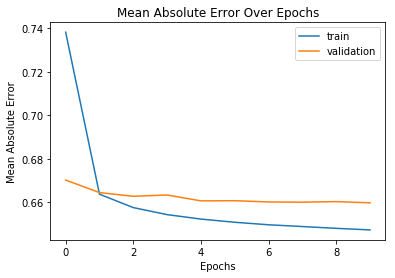

In [27]:
plt.plot(np.array(history.history['loss']))
plt.plot(np.array(history.history['val_loss']))
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.title('Mean Absolute Error Over Epochs')

## 2.1-) matrix_factorisation_model_with_n_latent_factors recommendation

In [28]:
mlp_user_embedding_weights = (next(iter(filter(lambda x: x.name == 'User-Embedding', model.layers))).get_weights())

# get the latent embedding for your desired user
user_latent_matrix = mlp_user_embedding_weights[0]

desired_user_id = 38
one_user_vector = user_latent_matrix[desired_user_id,:]
one_user_vector = np.reshape(one_user_vector, (1,a[min_index_rmse]))

from sklearn.cluster import KMeans

print('\nPerforming kmeans to find the nearest users...')
# get similar users
kmeans = KMeans(n_clusters=20, random_state=0, verbose=0).fit(user_latent_matrix)
desired_user_label = kmeans.predict(one_user_vector)
user_label = kmeans.labels_
neighbors = []
for user_id, user_label in enumerate(user_label):
    if user_label == desired_user_label:
        neighbors.append(user_id)
print('Found {0} neighbor users.'.format(len(neighbors)))


Performing kmeans to find the nearest users...
Found 708 neighbor users.


In [29]:
    # get the movies in 3 similar users' movies
    movies = []
    result_list=[]
    for user_id in neighbors:
        movies += list(ratings[ratings['userId'] == int(user_id)]['movieId'])
    movies = list(set(movies))
    result_list.append('Found {0} neighbor movies from these users.'.format(len(movies)))

    users = np.full(len(movies), desired_user_id, dtype='int32')
    items = np.array(movies, dtype='int32')

    result_list.append('Ranking most likely tracks using the NeuMF model...')
    # and predict movies for my user
    results = model.predict([users,items],batch_size=10, verbose=0) 
    results = results.tolist()
    result_list.append('Ranked the movies!')

    results = pd.DataFrame(results, columns=['pre_rating']).astype("float")
    items = pd.DataFrame(items, columns=['movieId'])
    results = pd.concat([items, results], ignore_index=True, sort=False, axis=1)
    results.columns =['movieId', 'pre_rating'] 
    results_df = pd.DataFrame(np.nan, index=range(len(results)), columns=['pre_rating','movieId'])
    for index, row in results.iterrows():
        results_df.loc[index] = [row['pre_rating'], ratings[ratings['movieId'] == row['movieId']].iloc[0]['movieId']]

    results_df= results_df.sort_values(by=['pre_rating'], ascending=False)
    results_df["movieId"]=results_df["movieId"].astype(int)
    results_df=pd.merge(results_df,movie_list,on="movieId")[:10]


In [30]:
results_df

,pre_rating,movieId,title,genres
0,4.790343,7056,"Public Enemy, The (1931)",Action|Crime|Drama
1,4.706107,647,Courage Under Fire (1996),Action|Crime|Drama|War
2,4.651084,3053,"Messenger: The Story of Joan of Arc, The (1999)",Drama|War
3,4.648019,5608,"Das Experiment (Experiment, The) (2001)",Drama|Thriller
4,4.589684,4170,Hit and Runway (1999),Comedy
5,4.575807,3048,Under the Rainbow (1981),Comedy
6,4.555152,7994,"Premature Burial, The (1962)",Horror
7,4.554189,731,Heaven's Prisoners (1996),Crime|Thriller
8,4.550573,5910,"Bolero (Uns et les autres, Les) (1981)",Drama|War
9,4.541239,6466,Mississippi Masala (1991),Drama|Romance


## 2.2-)svd matrix factorisation recommendation

In [32]:
#Convert predictions to a DataFrame
mf_pred = pd.DataFrame(X_pred, )
mf_pred.head()

,0,1,2,3,4,5,6,7,8,9,...,14016,14017,14018,14019,14020,14021,14022,14023,14024,14025
0,0.080523,0.031886,-0.009940,-0.035299,0.281212,0.026304,0.002676,-0.001686,0.191231,0.018933,...,-0.000547,-0.002779,0.000031,-0.000435,-0.000525,-0.000927,0.000362,-0.000047,-0.001306,0.523083
1,0.216171,0.128445,-0.003318,-0.122396,1.030300,0.184942,0.006577,-0.010009,0.582066,0.220946,...,-0.002998,-0.006255,0.000088,-0.000869,-0.001663,-0.004523,0.001562,-0.000306,-0.002607,1.833489
2,0.420980,0.228571,0.068529,0.258675,0.397981,0.249536,0.045365,0.100221,0.633579,0.421941,...,0.000579,-0.000482,0.000007,-0.000221,-0.000024,0.001053,-0.000105,0.000011,-0.000662,0.522147
3,0.899671,0.487292,0.143510,0.494983,1.111522,0.549209,0.089300,0.203065,1.476883,0.936430,...,-0.000034,-0.002454,0.000032,-0.000551,-0.000757,0.001019,0.000498,-0.000071,-0.001652,1.534186
4,0.260254,0.150467,0.040925,0.153853,0.247517,0.166831,0.031112,0.060728,0.372709,0.259520,...,0.000407,-0.000535,0.000009,-0.000233,0.000068,0.000336,-0.000238,-0.000013,-0.000698,0.353762


In [33]:
df_names = pd.merge(ratings,movie_list,on='movieId')
df_names.head()

,userId,movieId,rating,title,genres
0,0,1,3.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,4,1,3.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,12,1,3.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,28,1,3.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,33,1,3.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [34]:
#choose a user ID
user_id = 1
#get movies rated by this user id
users_movies = df_names.loc[df_names["userId"]==user_id]
#print how many ratings user has made 
print("User ID : " + str(user_id) + " has already rated " + str(len(users_movies)) + " movies")
#list movies that have been rated
users_movies.head()

User ID : 1 has already rated 59 movies


,userId,movieId,rating,title,genres
12683,1,254,5.0,Jefferson in Paris (1995),Drama
26381,1,531,5.0,"Secret Garden, The (1993)",Children|Drama
27979,1,577,5.0,Andre (1994),Adventure|Children|Drama
35944,1,886,5.0,Bulletproof (1996),Action|Comedy|Crime
48378,1,1142,5.0,Get Over It (1996),Drama


In [85]:
# fonksiyon yazılacak
user_index = train.loc[train["userId"]==user_id]['userId'][:1].values[0]
#get movie ratings predicted for this user and sort by highest rating prediction
sorted_user_predictions = pd.DataFrame(mf_pred.iloc[user_index].sort_values(ascending=False))
#rename the columns
sorted_user_predictions.columns=['ratings']
#save the index values as movie id
sorted_user_predictions['movieId']=sorted_user_predictions.index
print("Top 10 predictions for User " + str(user_id))
#display the top 10 predictions for this user
pd.merge(sorted_user_predictions,movie_list, on = 'movieId')[:10]

Top 10 predictions for User 1


,ratings,movieId,title,genres
0,2.637725,289,Only You (1994),Comedy|Romance
1,2.629090,580,Princess Caraboo (1994),Drama
2,2.562000,348,Bullets Over Broadway (1994),Comedy
3,2.428683,311,Relative Fear (1994),Horror|Thriller
4,2.320557,469,"House of the Spirits, The (1993)",Drama|Romance
5,2.318455,446,Farewell My Concubine (Ba wang bie ji) (1993),Drama|Romance
6,2.268703,576,Fausto (1993),Comedy
7,2.234048,106,Nobody Loves Me (Keiner liebt mich) (1994),Comedy|Drama
8,2.199088,253,Interview with the Vampire: The Vampire Chroni...,Drama|Horror
9,2.176442,48,Pocahontas (1995),Animation|Children|Drama|Musical|Romance
